In [1]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import random
import numpy as np
import pandas as pd
from models.aa_common.performance_metrics import *

In [2]:
task = "pmd"
model_root_and_name_tuple_list = [("dbnsfp", "sift"), ("dbnsfp", "polyphen2_HVAR"), ("dbnsfp", "cadd"), ("dbnsfp", "mvp"), ("dbnsfp", "metarnn"), ("dbnsfp", "revel"),
                                  ("tape_rao", "unirep"), ("tape_rao", "protbert"), ("sequnet_dunham", "sequnet"), 
                                  ("esm_rives", "esm1b_t33_650M_UR50S"), ("esm_rives", "esm1v_t33_650M_UR90S"), ("esm_rives", "esm2_t33_650M_UR50D"),
                                  ("bioembeddings_dallago", "plus_rnn"), 
                                  ("bioembeddings_dallago", "prottrans_bert_bfd"), ("bioembeddings_dallago", "prottrans_albert_bfd"),
                                  ("bioembeddings_dallago", "prottrans_xlnet_uniref100"), 
                                  ("bioembeddings_dallago", "prottrans_t5_bfd"), ("bioembeddings_dallago", "prottrans_t5_uniref50"), ("bioembeddings_dallago", "prottrans_t5_xl_u50"),
                                  ("vespa_marquet", "vespa"), ("", "random_classifier")]


# by default, we consider larger means positive class (here Effect), but the following models have specific opposite meaning
models_smaller_means_damaging = ["sequnet", "sift"]

metrics = ["KS-statistic", "KS-pvalue", "AUC-ROC", "AUC-PR", "F1-max", "Th-max", "Precision", "Recall", "Accuracy", "Balanced-accuracy", "MCC", "Missing values (%)"]

In [15]:
result_df = pd.read_csv(home_dir+f"models/aa_common/merged_predictions/{task}.tsv", sep="\t")
print(result_df.shape)
print(result_df.columns)
result_df.rename(columns={"functional_effect": "class"}, inplace=True)
result_df["class"].value_counts()

(60656, 52)
Index(['mut_id', 'pmd_id', 'nr', 'crossref', 'uniprot_id', 'ensembl_id',
       'taxid', 'protein', 'mut_PMD', 'mut_real', 'wt', 'mut', 'prot_pos',
       'function_summarized', 'functional_effect', 'function', 'seq', 'snp_id',
       'mrna_acc', 'mrna_ver', 'mrna_pos', 'allele', 'protein_acc',
       'protein_ver', 'verified', 'chrom', 'chrom_pos', 'variation',
       'variant_type', 'ref_allele', 'alt_allele', 'pmd_nr_id', 'sift_pred',
       'polyphen2_HVAR_pred', 'cadd_pred', 'mvp_pred', 'metarnn_pred',
       'revel_pred', 'unirep_pred', 'protbert_pred', 'sequnet_pred',
       'esm1b_t33_650M_UR50S_pred', 'esm1v_t33_650M_UR90S_pred',
       'esm2_t33_650M_UR50D_pred', 'plus_rnn_pred', 'prottrans_bert_bfd_pred',
       'prottrans_albert_bfd_pred', 'prottrans_xlnet_uniref100_pred',
       'prottrans_t5_bfd_pred', 'prottrans_t5_uniref50_pred',
       'prottrans_t5_xl_u50_pred', 'vespa_pred'],
      dtype='object')


Effect       28800
Knock-out    16616
No-effect    15240
Name: class, dtype: int64

### The following are the helper functions that computes the performance metrics for human and non-human analysis

In [24]:
def get_non_nan_df(df, col_name):
    non_nan_df = df[~pd.isna(df[col_name])]  # taking df for only non-NAN values
    
    n_missing = df[pd.isna(df[col_name])].shape[0] 
    total = df.shape[0]
    missing_values_percentage = (n_missing / total) * 100
    print(f"\tMissing values: 100*{n_missing}/{total}={missing_values_percentage}")
    
    return non_nan_df, missing_values_percentage

def calibrate_prediction_scores_direction(df, model_name):
    if model_name in models_smaller_means_damaging:
        df['pred'] = df['pred'].multiply(-1)
    
    auc_roc_score, larger_means_positive_class = get_auc_roc_score(df)
    if not larger_means_positive_class:
        df['pred'] = df['pred'].multiply(-1)
    
    return df, auc_roc_score

def sample_positive_and_negative_data_points(df, positive_cls, negative_cls, n_samples):
    df = df.copy(deep=True)
    positive_cls_result_df = df[df["class"]==positive_cls]
    negative_cls_result_df = df[df["class"]==negative_cls]
    
    positive_cls_result_df["class_numeric"] = 1
    negative_cls_result_df["class_numeric"] = 0

    positive_cls_result_df = positive_cls_result_df.sample(n=min(n_samples, positive_cls_result_df.shape[0]))
    negative_cls_result_df = negative_cls_result_df.sample(n=min(n_samples, negative_cls_result_df.shape[0]))

    print(f"\t{positive_cls}(+ve): {positive_cls_result_df.shape}, {negative_cls}(-ve): {negative_cls_result_df.shape}")
    
    result_df = pd.concat([positive_cls_result_df, negative_cls_result_df])
    return result_df

def compute_all_methods_all_metics(result_df, positive_cls, negative_cls, n_samples):
    performance_scores_dict = {}
    for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
        print(model_name)
        model_pred_col = model_name + "_pred"
        performance_scores = []

        for i_run in range(10): #10 runs
            if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]

            non_nan_result_df, missing_values_percentage = get_non_nan_df(result_df, model_pred_col)

            sampled_result_df = sample_positive_and_negative_data_points(non_nan_result_df, positive_cls, negative_cls, n_samples)
            
            sampled_result_df["pred"]=(sampled_result_df[model_pred_col]-sampled_result_df[model_pred_col].min())/(sampled_result_df[model_pred_col].max()-sampled_result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]
            
            non_nan_result_df = sampled_result_df
            non_nan_result_df, auc_roc_score =  calibrate_prediction_scores_direction(non_nan_result_df, model_name)
            
            ks_statistic, ks_pvalue = get_KS_test_score(non_nan_result_df)
            auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
            f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
            precision = get_precision_score(non_nan_result_df, th_max)
            recall = get_recall_score(non_nan_result_df, th_max)
            accuracy = get_accuracy_score(non_nan_result_df, th_max)
            balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
            mcc = get_matthews_corrcoef(non_nan_result_df, th_max)
            
            performance_scores.append([ks_statistic, ks_pvalue, auc_roc_score, auc_pr_score, f1_max, th_max, precision, recall, accuracy, balanced_accuracy, mcc, missing_values_percentage])
            print()
            
        performance_scores_dict[model_name] = performance_scores
    return performance_scores_dict

In [25]:
# output_file = home_dir+f"models/aa_common/performance_analysis/{task}.tsv"

def write_metrics_outputs(performance_scores_dict, output_file):
    out = open(output_file, 'w')
    out.write("Models\\Metrics")
    for metric in metrics:
        out.write(f"\t{metric}")
    out.write("\n")

    for (model_name, performance_scores) in performance_scores_dict.items():
        out.write(f"{model_name}")
        for scores in performance_scores:
            for score in scores:
                out.write(f"\t{score:.3f}")
            out.write("\n")
        out.write("\n")
        
    for (model_name, performance_scores) in performance_scores_dict.items():
        out.write(f"{model_name}")    
        avg_scores = np.mean(performance_scores, axis=0)
        std_scores = np.std(performance_scores, axis=0)
        for i in range(len(avg_scores)):
            out.write(f"\t{avg_scores[i]:.3f}({std_scores[i]:.3f})")
        out.write("\n")
    out.close()

### Human: Effect vs. No-effect and Knock-out vs. No-effect

In [30]:
# print("#-human (taxid)", result_df[result_df["taxid"]=="9606"].shape) # # number of human entries using taxid: 14072. no longer using this.
human_result_df = result_df[result_df["crossref"].apply(lambda x: True if "HUMAN" in x else False)] # number of human entries: 16996
print(human_result_df.shape)
human_result_df["class"].value_counts()

positive_cls, negative_cls = "Effect", "No-effect"
performance_scores_dict = compute_all_methods_all_metics(human_result_df, positive_cls, negative_cls, n_samples=3000)
write_metrics_outputs(performance_scores_dict, output_file=home_dir+f"models/aa_common/performance_analysis/{task}_human_{positive_cls}_vs_{negative_cls}_analysis.tsv")

positive_cls, negative_cls = "Knock-out", "No-effect"
performance_scores_dict = compute_all_methods_all_metics(human_result_df, positive_cls, negative_cls, n_samples=3000)
write_metrics_outputs(performance_scores_dict, output_file=home_dir+f"models/aa_common/performance_analysis/{task}_human_{positive_cls}_vs_{negative_cls}_analysis.tsv")

(16996, 52)


Effect       8380
Knock-out    4382
No-effect    4234
Name: class, dtype: int64

### Non-Human: Effect vs. No-effect and Knock-out vs. No-effect

In [31]:
non_human_result_df = result_df[result_df["crossref"].apply(lambda x: False if "HUMAN" in x else True)] # number of human entries: 43660
print(non_human_result_df.shape)
non_human_result_df["class"].value_counts()

positive_cls, negative_cls = "Effect", "No-effect"
performance_scores_dict = compute_all_methods_all_metics(non_human_result_df, positive_cls, negative_cls, n_samples=3000)
write_metrics_outputs(performance_scores_dict, output_file=home_dir+f"models/aa_common/performance_analysis/{task}_nonhuman_{positive_cls}_vs_{negative_cls}_analysis.tsv")

positive_cls, negative_cls = "Knock-out", "No-effect"
performance_scores_dict = compute_all_methods_all_metics(non_human_result_df, positive_cls, negative_cls, n_samples=3000)
write_metrics_outputs(performance_scores_dict, output_file=home_dir+f"models/aa_common/performance_analysis/{task}_nonhuman_{positive_cls}_vs_{negative_cls}_analysis.tsv")

(43660, 52)


Effect       20420
Knock-out    12234
No-effect    11006
Name: class, dtype: int64

### Plotting the prediction score distributions

unirep
	Missing values: 100*0/43660=0.0


/tmp/ipykernel_3760094/1662790352.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


protbert
	Missing values: 100*0/43660=0.0


/tmp/ipykernel_3760094/1662790352.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


sequnet
	Missing values: 100*215/43660=0.4924415941365094


/tmp/ipykernel_3760094/1662790352.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]
/tmp/ipykernel_3760094/1662790352.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)


esm1b_t33_650M_UR50S
	Missing values: 100*0/43660=0.0


/tmp/ipykernel_3760094/1662790352.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


esm1v_t33_650M_UR90S
	Missing values: 100*0/43660=0.0


/tmp/ipykernel_3760094/1662790352.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


esm2_t33_650M_UR50D
	Missing values: 100*0/43660=0.0


/tmp/ipykernel_3760094/1662790352.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


plus_rnn
	Missing values: 100*168/43660=0.3847915712322492


/tmp/ipykernel_3760094/1662790352.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


prottrans_bert_bfd
	Missing values: 100*168/43660=0.3847915712322492


/tmp/ipykernel_3760094/1662790352.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


prottrans_albert_bfd
	Missing values: 100*168/43660=0.3847915712322492


/tmp/ipykernel_3760094/1662790352.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


prottrans_xlnet_uniref100
	Missing values: 100*168/43660=0.3847915712322492


/tmp/ipykernel_3760094/1662790352.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


prottrans_t5_bfd
	Missing values: 100*168/43660=0.3847915712322492


/tmp/ipykernel_3760094/1662790352.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


prottrans_t5_uniref50
	Missing values: 100*168/43660=0.3847915712322492


/tmp/ipykernel_3760094/1662790352.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


prottrans_t5_xl_u50
	Missing values: 100*168/43660=0.3847915712322492


/tmp/ipykernel_3760094/1662790352.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


vespa
	Missing values: 100*0/43660=0.0


/tmp/ipykernel_3760094/1662790352.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


random_classifier
	Missing values: 100*0/43660=0.0


/tmp/ipykernel_3760094/1662790352.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[model_pred_col] = [random.uniform(0,1) for i in range(df.shape[0])]
/tmp/ipykernel_3760094/1662790352.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


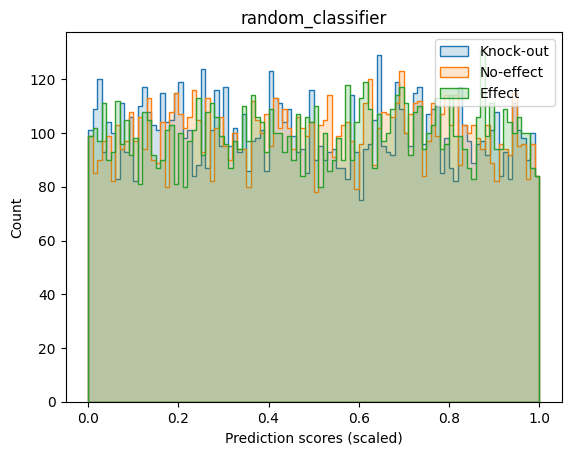

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution(result_df, out_dir, n_samples=None):
    df = result_df.copy(deep=True)
    plt.cla()

    effect = result_df[result_df["functional_effect"]=="Effect"]
    knock_out = result_df[result_df["functional_effect"]=="Knock-out"]
    no_effect = result_df[result_df["functional_effect"]=="No-effect"]

    if n_samples:
        effect = effect.sample(n=n_samples)
        knock_out = knock_out.sample(n=n_samples)
        no_effect = no_effect.sample(n=n_samples)

    bins = 100 # 20, 100, 500
    # plt.hist(knock_out["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Knock-out")
    # plt.hist(no_effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"No-effect")
    # plt.hist(effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Effect")
    
    
    sns.histplot(knock_out["pred"], bins=bins, label=f"Knock-out", element="step", alpha=.2)
    sns.histplot(no_effect["pred"], bins=bins, label=f"No-effect", element="step", alpha=.2)
    sns.histplot(effect["pred"], bins=bins, label=f"Effect", element="step", alpha=.2)
    
    plt.title(f"{model_name}")
    plt.legend()
    plt.xlabel("Prediction scores (scaled)")
    plt.ylabel("Count")
    # plt.show()
    plt.savefig(home_dir+f"{out_dir}{model_name}.png", dpi=300, format="png", bbox_inches='tight', pad_inches=0.0)

# df = result_df[result_df["crossref"].apply(lambda x: True if "HUMAN" in x else False)] # number of human entries: 16996
# out_dir="models/aa_common/pred_scores_distribution_plots_pmd_human_analysis/"
# n_samples=None
is_dbnsfp_ok = True

df = result_df[result_df["crossref"].apply(lambda x: False if "HUMAN" in x else True)] # number of human entries: 43660
out_dir="models/aa_common/pred_scores_distribution_plots_pmd_nonhuman_analysis/"
n_samples=10000
is_dbnsfp_ok = False

for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    # model_name = "esm2_t33_650M_UR50D"
    if model_root=="dbnsfp" and ~is_dbnsfp_ok: continue
    
    print(model_name)
    model_pred_col = model_name + "_pred"
    if model_name=="random_classifier": 
        df[model_pred_col] = [random.uniform(0,1) for i in range(df.shape[0])]

    df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]

    non_nan_result_df, _ = get_non_nan_df(df, model_pred_col)
        
    if model_name in models_smaller_means_damaging:
        non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)

    plot_distribution(non_nan_result_df, out_dir, n_samples)
    # break



	AUC-PR: 0.361
(25873,)
	Best F1-Score: 0.655 at threshold: 0.000
(25868,)
[0.48721607 0.4871963  0.48717652 ... 0.14285714 0.16666667 1.        ]
[1.00000000e+00 9.99920849e-01 9.99841697e-01 ... 7.91514960e-05
 7.91514960e-05 0.00000000e+00]


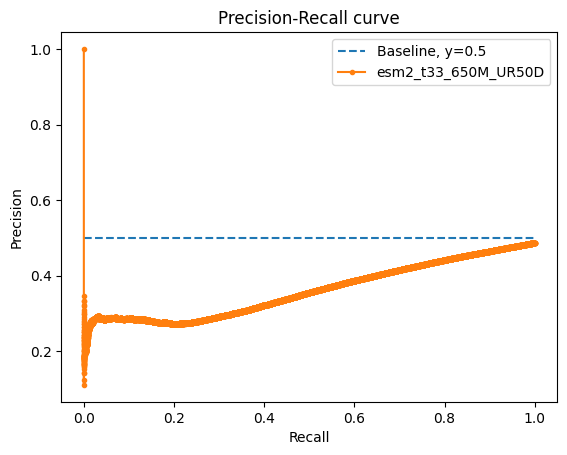

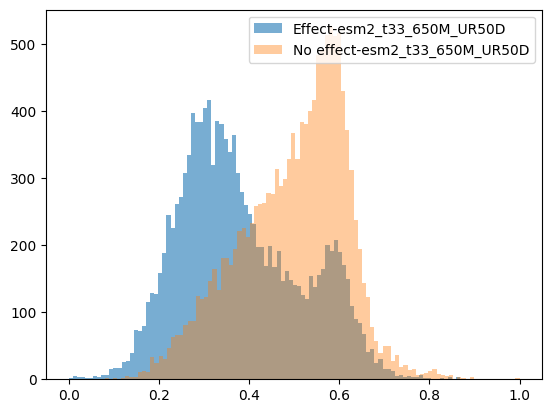

In [7]:

    

model_name = "esm2_t33_650M_UR50D"
model_pred_col = model_name + "_pred"

result_df.loc[result_df["functional_effect"]=="Effect", "class_numeric"] = 1
result_df.loc[result_df["functional_effect"]=="No effect", "class_numeric"] = 0

result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]

non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values

if model_name in models_smaller_means_damaging:
    non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
print(thresholds.shape)
f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
print(thresholds.shape)
print(precisions, recalls, sep="\n")

# f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th_(non_nan_result_df)

import matplotlib.pyplot as plt
plt.plot([0,1], [.5, .5], linestyle='--', label='Baseline, y=0.5')
plt.plot(recalls, precisions, marker='.', label=f'{model_name}')
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.title("Precision-Recall curve")
plt.show()


effect = result_df[result_df["functional_effect"]=="Effect"]
no_effect = result_df[result_df["functional_effect"]=="No effect"]

bins = 100 # 20, 100, 500
plt.hist(effect["pred"], bins=bins, density=False, log=False, alpha=.6, label=f"Effect-{model_name}")
plt.hist(no_effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"No effect-{model_name}")

plt.legend()
plt.show()